<a href="https://colab.research.google.com/github/Lamblador/IR_expert_system/blob/main/Koshelev_IR_expert_system_3_SHAP_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IR spectral analysis of organic and coordination compounds via machine learning and neural networks
By: Koshelev Daniil 

Based on some code form: https://github.com/rayguna/IR-Spectra-Analyzer
Предыдущая часть: https://github.com/Lamblador/IR_expert_system/blob/main/Koshelev_IR_expert_system_1_Dataset_Preparation.ipynb

-Work in progress (last updated:04/04/2023)-

B. Цель данного блокнота

Целью этого блокнота является использование SHAP на предобученной модели для понимания области наблюдения для каждого класса.

C. План реализации

1. Импортировать данные и модель
2. Реализовать расчет shap values
3. Реализовать построение графика для shap values и одного спектра

NOTES
1. Импортированы данные и модель
2. Получены данные shap values
3. Реализована функция визуализации

Клонирование данных с GitHub. На сайте выложены как исходные списки веществ, так и скачанные спектры соединений, которые были запарсены кодом ниже.

In [1]:
!git clone https://github.com/Lamblador/IR_expert_system.git

Cloning into 'IR_expert_system'...
remote: Enumerating objects: 16850, done.
remote: Counting objects: 100% (2007/2007), done.
remote: Compressing objects: 100% (1915/1915), done.
remote: Total 16850 (delta 103), reused 1988 (delta 91), pack-reused 14843
Receiving objects: 100% (16850/16850), 613.79 MiB | 24.89 MiB/s, done.
Resolving deltas: 100% (463/463), done.
Updating files: 100% (16657/16657), done.


In [2]:
# Установка нужных пакетов
from IPython.core.display import clear_output
!pip install --upgrade jcamp
!pip install torchmetrics
!pip install shap
!pip install peakutils
clear_output()

In [3]:
# Вводятся нужные импорты
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import os
import numpy as np
import torch
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import shap
import torch.nn as nn
from peakutils.peak import indexes as index_utils


In [58]:
import random

import torch
import torch.nn as nn
from torchvision import datasets, transforms


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

# Импорт табличных данных

In [4]:
labels_df = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')
labels_df = labels_df.set_index("CAS")

Импорт данных и обработка спектров

In [5]:
from jcamp import jcamp_readfile
nist_ir_spectra_list_with_group = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')
# Create an empty list to store spectra data
ref_spectra = []
# choose current directory
curr_directory = os.getcwd()
os.chdir(curr_directory)  # set to current directory
files = glob.glob('/content/IR_expert_system/downloaded_jcamp/ir/*')  # look for files without extension. Returns a list.
# Try to read the file. If can't be read, skip it.
dataset_dic = {}
for i, file in enumerate(files):
    
    #print(file)
    try:
        # read jcamp file using the jcamp class and store data into the
        # ref_spectra list
        sample = jcamp_readfile(file)
        #Forming data into the types
        sample['x'] = sample['x'].astype(np.float32)
        sample['y'] = sample['y'].astype(np.float32)
        sample['firstx'] = np.float32(sample['x'][0])
        #print(type(sample['firstx']))
        sample['deltax'] = ((np.float32(sample['firstx'])-np.float32(sample['lastx']))/np.float32(sample['npoints']))
        sample['npoints'] = int(sample['npoints'])    
        # uniformize data, #1:
        # check yunits: If yunits is in transmission, change it to absorbance.
        # Later create a function to uniformize units
        if sample['yunits'] == "ABSORBANCE":
            pass 

        elif sample['yunits'] == "TRANSMISSION" or sample['yunits'] == "TRANSMITTANCE":
            
            sample['y'] = 1 - sample['y']
            sample['yunits'] = "ABSORBANCE"
            
            #normalize
           
        # check xunits: if in microns, change to 1/cm

        if sample['xunits'] == "MICROMETERS":
            sample['x'] = 10000 / sample['x']
            sample['xunits'] = '1/CM'
            sample['firstx'] = np.float32(sample['x'][0])
            sample['lastx'] = np.float32(sample['x'][int(sample['npoints'])-1])
            sample['deltax'] = ((np.float32(sample['firstx'])-np.float32(sample['lastx']))/np.float32(sample['npoints']))
            #if sample['deltax'] == np.nan: print(float(sample['firstx'])-float(sample['lastx'])), float(sample['npoints'])
            sample['maxx'] =  np.float32(max(sample['x']))
            sample['minx'] =  np.float32(min(sample['x']))
        # check deltax: if Nan, change to (maxx-minx)/npoints
        #if sample['deltax'] == np.nan: sample['deltax'] = ((float(sample['firstx'])-float(sample['lastx']))/float(sample['npoints']))

        # !Still need to uniformize x-axis range and uniformize x-axis intervals.
        #Flitting the x array if it is not in min_to_max order
        if sample['x'][0] > sample['x'][3]: 
           #print(sample['x'])
           sample['x'] = np.flip(sample['x'])
           #print(sample['x'])
           sample['y'] = np.flip(sample['y'])
           sample['firstx'] = np.float32(sample['x'][0])
           sample['lastx'] = np.float32(sample['x'][int(sample['npoints'])-1])
           
        
        #Saving data to dictionary under cas num
        dataset_dic[sample['cas registry no']] = sample
        #print(sample['cas registry no'])
        # Nan check
        if np.isnan(sample['y']).any(): print("Reading jcamp problem! Nan observed in Y")
                

    except:
         print("File can't be read, please check:", file)
         continue

#print(dataset_dic)

File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/3871-23-6
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/116295-53-5
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/99972-22-2
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/7631-86-9
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/6596-69-6
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/116401-36-6
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/116402-66-5
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/51892-04-7
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/2467-03-0
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/502-99-8
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/7398-82-5
Fil

In [6]:
dataset_df = pd.DataFrame(dataset_dic)
dataset_df = dataset_df.transpose()
dataset_df[['x', 'y', 'minx', 'maxx', 'npoints']]

,x,y,minx,maxx,npoints
615-54-3,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[0.054759964, 0.04684099, 0.058848847, 0.06609...",450,3966,880
930-99-4,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[0.0002106, 0.0001456, 0.0001716, 0.0002418, 0...",550,3846,825
33901-44-9,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[0.004623, 0.003723, 0.003733, 0.003493, 0.003...",549.759,4000.7,1790
3397-62-4,"[649.9584, 650.2457, 650.53174, 650.81793, 651...","[0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.3...",649.958374,4916.420898,1977
74-85-1,"[454.005, 454.94366, 455.88235, 456.821, 457.7...","[-0.014000058, -0.014000058, -0.014000058, -0....",454.005,3795.69,3561
...,...,...,...,...,...
6340-79-0,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[0.01919, 0.01902, 0.01907, 0.01857, 0.01853, ...",549.759,4000.7,1790
103-60-6,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[0.04065232, 0.033513375, 0.007634704, 0.01060...",450,3966,880
10364-94-0,"[549.766, 551.695, 553.624, 555.553, 557.482, ...","[0.001108, 0.000815, 0.001101, 0.001443, 0.001...",549.766,4000.75,1790
629-17-4,"[549.863, 551.7923, 553.7216, 555.6509, 557.58...","[0.00041007, 0.00042691, 0.00042051, 0.0004924...",549.863,3999.53,1789


In [7]:
#Добавление к краям с исходным шагом крайнего значения y.
def padding_ir_below(x, y, low_border):
  '''
    x, y - array-like data
    low_border - border until which padding will continue 

    return padded x and y as lists
  '''
  x, y = list(x), list(y)
  deltax = x[1]-x[0]
  next_x = x[0]-deltax
  while next_x > low_border:
    x.insert(0, next_x)
    y.insert(0, y[0])
    next_x = x[0]-deltax
  #Последняя итерация чтобы выйти за границу интерполирования
  x.insert(0, next_x)
  y.insert(0, y[0])
  next_x = x[0]-deltax
  return x, y

def padding_ir_above(x, y, high_border):
  '''
    x, y - array-like data
    high_border - border until which padding will continue 


    return padded x and y as lists
  '''
  x, y = list(x), list(y)
  deltax = x[1]-x[0]
  next_x = x[-1]+deltax
  while next_x < high_border:
    x.append(next_x)
    y.append(y[-1])
    next_x = x[-1]+deltax
  #Последняя итерация чтобы выйти за границу интерполирования
  x.append(next_x)
  y.append(y[-1])
  next_x = x[-1]+deltax
  return x, y

from scipy import interpolate

def interpolate_in_borders_with_delta(x, y, borders = [500, 4100], deltax = 2):
  '''
  x, y - array like data
  borders - list of [low_border, high border]
  deltax - increment of new data

  returns new x, y data as lists with increment = deltax
  '''
  x, y = list(x), list(y)
  f = interpolate.interp1d(x, y)
  #print(f(x[0]))
  x_new = []
  for i in range(borders[0], borders[1], deltax):
    x_new.append(i)
  x_new = np.array(x_new)
  y_new = f(x_new)
  
  return x_new, y_new

def find_peaks_indx(y):
  index = index_utils(np.array(y), thres=0.05*max(y), min_dist=10, thres_abs = True)
  return index



In [8]:
x_list, y_list = [], []
y_peak_indx_list = []
errors = 0
for i in tqdm(range(len(dataset_df[['x']]))):
  try:
      x, y = dataset_df[['x']].iloc[i].tolist(), dataset_df[['y']].iloc[i].tolist()
      x1, y1 = padding_ir_below(x[0], y[0], 500.0)

      x2, y2 = padding_ir_above(x1, y1, 4100.0)
  
      x3, y3 = interpolate_in_borders_with_delta(x2, y2)
      y_peak_indx = find_peaks_indx(y3)
      y_peak_indx_list.append(y_peak_indx)
      x_list.append(x3)
      y_list.append(y3)
  except ValueError:
      #print(f'0: {len(x)}, {len(y)}, 1: {len(x1)}, {len(y1)}, 2: {len(x2)}, {len(y2)}')
      errors +=1
      x_list.append(np.nan)
      y_list.append(np.nan) 
      y_peak_indx_list.append(np.nan)
print(f'Found {errors} errors')


100%|██████████| 14346/14346 [02:33<00:00, 93.64it/s]

Found 38 errors


In [ ]:
print(len(y_peak_indx_list), len(y_list), len(y_list))

In [ ]:
#Создаём дополнительный слой для входа в сеть, где +/- вокруг пика будет от 0 до 1, а вне - 0.
#def print_peak_neighborhood(peak_indx, num_neighbors = 10):
num_neighbors = 10
y_masked_list = []
for i in range(len(y_list)):
  try:
    y_masked = np.zeros(len(y_list[i]))
  
    for j in y_peak_indx_list[i]:
      for k in range(num_neighbors):
          y_masked[j-k] = 1-(1/num_neighbors)*k
          y_masked[j+k] = 1-(1/num_neighbors)*k
          
      #print(y_masked[28:48])
      
          
      
    y_masked_list.append(y_masked)
  except:
    y_masked_list.append(np.nan)

In [ ]:
x_serie = pd.Series(x_list)
y_serie = pd.Series(y_list)
y_peak_serie = pd.Series(y_masked_list)

In [12]:
df = pd.DataFrame(x_serie, columns = ['x1'])
df['y1'] = y_serie
df['y_peak'] = y_masked_list

In [13]:
dataset_df = dataset_df.reset_index()
dataset_df1 = dataset_df.join(df, lsuffix='x')
dataset_df1[['x', 'x1', 'y', 'y1', 'y_peak']]

,x,x1,y,y1,y_peak
0,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.054759964, 0.04684099, 0.058848847, 0.06609...","[0.007479031104594469, 0.008436554111540318, 0...","[0.0, 0.0, 0.09999999999999998, 0.199999999999..."
1,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0002106, 0.0001456, 0.0001716, 0.0002418, 0...","[0.0002106000029016286, 0.0002106000029016286,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.004623, 0.003723, 0.003733, 0.003493, 0.003...","[0.004623000044375658, 0.004623000044375658, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[649.9584, 650.2457, 650.53174, 650.81793, 651...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.3...","[0.38999998569488525, 0.38999998569488525, 0.3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[454.005, 454.94366, 455.88235, 456.821, 457.7...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[-0.014000058, -0.014000058, -0.014000058, -0....","[-0.05900021035809999, -0.05813053804132551, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
14341,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.01919, 0.01902, 0.01907, 0.01857, 0.01853, ...","[0.019190000370144844, 0.019190000370144844, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14342,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.04065232, 0.033513375, 0.007634704, 0.01060...","[0.05334377661347389, 0.0681174248456955, 0.05...","[0.9, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.39999999..."
14343,"[549.766, 551.695, 553.624, 555.553, 557.482, ...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.001108, 0.000815, 0.001101, 0.001443, 0.001...","[0.0011080000549554825, 0.0011080000549554825,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14344,"[549.863, 551.7923, 553.7216, 555.6509, 557.58...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.00041007, 0.00042691, 0.00042051, 0.0004924...","[0.0004100700025446713, 0.0004100700025446713,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [14]:
dataset_df1 = dataset_df1.set_index('cas registry no')

In [15]:
dataset_df_labeled = labels_df.join(dataset_df1)

In [16]:
dataset_df_labeled1 = dataset_df_labeled[['Name', 'Formula', 'Mw', 'Elements', 'InChi', 'SMILES', 'alkane',
       'methyl', 'alkene', 'alkyne', 'alcohols', 'amines', 'nitriles',
       'aromatics', 'alkyl halides', 'esters', 'ketones', 'aldehydes',
       'carboxylic acids', 'ether', 'acyl halides', 'amides', 'nitro',
       'title',
       'molform',
       'x', 'y', 'x1', 'y1', 'y_peak']]
#dataset_df_labeled1

In [17]:
spectra_x =dataset_df_labeled.iloc[:,-1]
spectra_x_t = torch.Tensor(spectra_x[0])
#spectra_x_t

# Создание класса Dataset

Вивлеты - преобразование для детектирования пиков.

In [18]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class IRSpectraDataset(Dataset):
    def __init__(self, dataset_df_labeled):
        self.dataset_df = dataset_df_labeled
        self.spectra_labels = self.dataset_df.iloc[:,6:23]
        self.spectra_x = self.dataset_df.iloc[:,-3]
        self.spectra_y = self.dataset_df.iloc[:,-2]
        self.spectra_y_peak = self.dataset_df.iloc[:,-1]
        
    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):
        
        spectra_x = torch.Tensor(self.spectra_x.iloc[idx]).reshape((1, 1800))
        spectra_y = torch.Tensor(self.spectra_y.iloc[idx]).reshape((1, 1800)) 
        spectra_y_peak = torch.Tensor(self.spectra_y_peak.iloc[idx]).reshape((1, 1800))     
        spectra = torch.cat((spectra_x, spectra_y, spectra_y_peak))
        
        label = torch.Tensor(self.spectra_labels.iloc[idx])
        #transform
        return spectra, label

In [19]:
dataset_ir_spectra = IRSpectraDataset(dataset_df_labeled1)

In [20]:
#Создание объекта класса и разбиение на трейн,тест и вал
from torch.utils.data import random_split
dataset_ir_spectra = IRSpectraDataset(dataset_df_labeled1.dropna())
train_size = int(0.7 * len(dataset_ir_spectra))
val_size = int(0.1 * len(dataset_ir_spectra))
test_size = len(dataset_ir_spectra) - train_size - val_size
train_dataset, test_dataset = random_split(dataset_ir_spectra, [train_size, int(test_size+val_size)])
test_dataset, val_dataset = random_split(test_dataset, [test_size, val_size])

In [21]:
#Создание загрузчиков
# Number of classes
classes = list(dataset_ir_spectra.spectra_labels.columns)
num_classes = len(classes)
num_classes

17

In [22]:
cls2inx = {}
inx2cls= {}
for i, classs in enumerate(classes):
  cls2inx[f'{classs}']= i
  inx2cls[i] = classs
print(cls2inx)
print(inx2cls)

{'alkane': 0, 'methyl': 1, 'alkene': 2, 'alkyne': 3, 'alcohols': 4, 'amines': 5, 'nitriles': 6, 'aromatics': 7, 'alkyl halides': 8, 'esters': 9, 'ketones': 10, 'aldehydes': 11, 'carboxylic acids': 12, 'ether': 13, 'acyl halides': 14, 'amides': 15, 'nitro': 16}
{0: 'alkane', 1: 'methyl', 2: 'alkene', 3: 'alkyne', 4: 'alcohols', 5: 'amines', 6: 'nitriles', 7: 'aromatics', 8: 'alkyl halides', 9: 'esters', 10: 'ketones', 11: 'aldehydes', 12: 'carboxylic acids', 13: 'ether', 14: 'acyl halides', 15: 'amides', 16: 'nitro'}


In [23]:
# Расчёт весов
wts4cls = {}
for classs in classes:
  wts4cls[classs] = dataset_ir_spectra.spectra_labels[classs].mean()
print(wts4cls)

{'alkane': 0.6826680141485599, 'methyl': 0.6217786760990399, 'alkene': 0.13550614788613777, 'alkyne': 0.019538487451574868, 'alcohols': 0.21862893717365672, 'amines': 0.13078996125989556, 'nitriles': 0.038150581101566446, 'aromatics': 0.5845544887990568, 'alkyl halides': 0.2593902644433215, 'esters': 0.11630453090786592, 'ketones': 0.09415529728819269, 'aldehydes': 0.020633316489809667, 'carboxylic acids': 0.060384032339565435, 'ether': 0.2499578911908371, 'acyl halides': 0.009600808489135927, 'amides': 0.0708270170119589, 'nitro': 0.057267980461512547}


In [24]:
#Веса классов
wts_list = []
for name, values in wts4cls.items():
  wts_list.append(values)
weight_for_every_class = torch.tensor(wts_list)
print(weight_for_every_class)

tensor([0.6827, 0.6218, 0.1355, 0.0195, 0.2186, 0.1308, 0.0382, 0.5846, 0.2594,
        0.1163, 0.0942, 0.0206, 0.0604, 0.2500, 0.0096, 0.0708, 0.0573],
       dtype=torch.float64)


In [25]:
#Модифицирование весов для каждого класс:
level = 0.3
grain = 0.15
lg = level/grain
print(lg)
#Классы меньше grain процентов - увеличиваются в level/20 раза 
#Классы меньше 10 процентов - увеличиваются в level/10 раз 
#Классы меньше 5 процентов - увеличиваются в level/5 раз
#Классы меньше 1 процента - увеличиваются в level раз
weight_for_every_class_modified = []
for i in weight_for_every_class:
  if i <= grain/8: weight_for_every_class_modified.append(i/(32/lg))
  elif (i <= grain/4) and (i>grain/8): weight_for_every_class_modified.append(i/(16/lg))
  elif (i <= grain/2) and (i>grain/4): weight_for_every_class_modified.append(i/(8/lg))
  elif (i <= grain) and (i>grain/2): weight_for_every_class_modified.append(i/(4*lg))
  else: weight_for_every_class_modified.append(i)
weight_for_every_class_modified = torch.Tensor(weight_for_every_class_modified)
print(weight_for_every_class)
print(weight_for_every_class_modified)
print(weight_for_every_class_modified.size())

2.0
tensor([0.6827, 0.6218, 0.1355, 0.0195, 0.2186, 0.1308, 0.0382, 0.5846, 0.2594,
        0.1163, 0.0942, 0.0206, 0.0604, 0.2500, 0.0096, 0.0708, 0.0573],
       dtype=torch.float64)
tensor([6.8267e-01, 6.2178e-01, 1.6938e-02, 2.4423e-03, 2.1863e-01, 1.6349e-02,
        9.5376e-03, 5.8455e-01, 2.5939e-01, 1.4538e-02, 1.1769e-02, 2.5792e-03,
        1.5096e-02, 2.4996e-01, 6.0005e-04, 1.7707e-02, 1.4317e-02])
torch.Size([17])


In [26]:
#Расчёт веса образца на основе минимального веса любой функциональной группы 
labels1 = train_dataset.dataset.spectra_labels.to_numpy().copy()
labels1[labels1 == 0.0] = 100
#labels1

In [27]:
train_labels = torch.tensor(labels1)
weighted_labels  = train_labels*weight_for_every_class
weights_for_every_sample = []
for label_tensor in weighted_labels:
  weight = np.nanmin(label_tensor.numpy())
  weights_for_every_sample.append(weight)

weights_for_every_sample = torch.tensor(weights_for_every_sample)
print(weights_for_every_sample)

tensor([0.0573, 0.0573, 0.0573,  ..., 0.2594, 0.0573, 0.1308],
       dtype=torch.float64)


In [28]:
weights_train = weights_for_every_sample[:len(train_dataset)]

In [29]:
weights_train

tensor([0.0573, 0.0573, 0.0573,  ..., 0.0708, 0.0604, 0.2186],
       dtype=torch.float64)

In [30]:
#Проверка на положительные вероятности
for i in range(len(weights_train)):
    if weights_train[i] < 0:
        weights_train[i] = abs(weights_train[i])

In [31]:
weights_train[weights_train<0]

tensor([], dtype=torch.float64)

In [32]:
#Сумма весов должна быть равна единице. Вычисление суммы:
sum_weights = 0
for i in range(len(weights_train)):
 
  #print(weights_train[i])
  if weights_train[i] == torch.tensor(np.nan, dtype=torch.float64) : weights_train[i] = 1
  #print(weights_train[i])
  #print(sum_weights)
  sum_weights +=weights_train[i].numpy()
print(sum_weights)

1744.058783897611


In [33]:
#Сумма весов должна быть равна единице. Нормирование на сумму.
for i in range(len(weights_train)):
    weights_train[i] =  weights_train[i]/sum_weights

In [34]:
weights_train

tensor([3.2836e-05, 3.2836e-05, 3.2836e-05,  ..., 4.0610e-05, 3.4623e-05,
        1.2536e-04], dtype=torch.float64)

In [35]:
#Даталоадер

from torch.utils.data import DataLoader, WeightedRandomSampler

# Batch size
batch_size = 128

dataloader_ir_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_ir_val = DataLoader(val_dataset, batch_size=val_size, shuffle=False)
weightedsampler = WeightedRandomSampler(weights_train, len(weights_train)) 

dataloader_ir_train = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler= weightedsampler
)

# Модель

In [42]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet4(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet4, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(3, hidden_size, kernel_size=3, stride=2, padding = 1) #[3,899]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        
        
        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        # self.layer2 = nn.Sequential(
        #     BasicBlock(hidden_size, downsample = False), #[2,1800]
        #     BasicBlock(hidden_size),
        #     BasicBlock(hidden_size))
        #self.max1 = nn.MaxPool1d(3,2,0)
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        # self.layer4 = nn.Sequential(
        #     BasicBlock(hidden_size*2, downsample = False), 
        #     BasicBlock(hidden_size*2),
        #     BasicBlock(hidden_size*2))
        #self.max2 = nn.MaxPool1d(3,2,0)
        self.layer5 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        # self.layer6 = nn.Sequential(
        #     BasicBlock(hidden_size*4, downsample = False), 
        #     BasicBlock(hidden_size*4),
        #     BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)
        self.layer7 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        # self.layer8 = nn.Sequential(
        #     BasicBlock(hidden_size*8, downsample = False), #[2,225]
        #     BasicBlock(hidden_size*8),
        #     BasicBlock(hidden_size*8))
        #self.adppool = nn.AdaptiveMaxPool1d(14)
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*56, 200)
        self.do2 = nn.Dropout1d(0.2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums) 
        #self.sm = nn.Sigmoid()
        


    def forward(self, batch):
      # PUT YOUR CODE HERE
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        #batch = self.layer2(batch)
        #batch = self.max1(batch)
        batch = self.layer3(batch)
        #batch = self.layer4(batch)
        #batch = self.max2(batch)
        batch = self.layer5(batch)
        #batch = self.layer6(batch)
        batch = self.max3(batch)
        batch = self.layer7(batch)
        #batch = self.layer8(batch)
        #batch = self.adppool(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.do2(batch)
        batch = self.relu1(batch)
        scores = self.fc1(batch)
        
        #scores=self.sm(batch)
              
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()
        
        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))                

       
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out

## Импорт модели

In [43]:
model = IrResnet4(50)
model.load_state_dict(torch.load('/content/IR_expert_system/models/v0.5.1.50/v0.5.1.50_model_param'))
model.eval()

IrResnet4(
  (conv1): Conv1d(3, 50, kernel_size=(3,), stride=(2,), padding=(1,))
  (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): BasicBlock(


In [44]:
from torchsummary import summary
summary(model.to('cpu'), (3, 1800))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 50, 900]             500
       BatchNorm1d-2              [-1, 50, 900]             100
              ReLU-3              [-1, 50, 900]               0
            Conv1d-4              [-1, 50, 900]           7,550
       BatchNorm1d-5              [-1, 50, 900]             100
              ReLU-6              [-1, 50, 900]               0
            Conv1d-7              [-1, 50, 900]           7,550
       BatchNorm1d-8              [-1, 50, 900]             100
              ReLU-9              [-1, 50, 900]               0
       BasicBlock-10              [-1, 50, 900]               0
           Conv1d-11              [-1, 50, 900]           7,550
      BatchNorm1d-12              [-1, 50, 900]             100
             ReLU-13              [-1, 50, 900]               0
           Conv1d-14              [-1, 

# Расчет SHAP values

https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html

# Функция визуализации

In [45]:
# plot the feature attributions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
def calc_shap_values(model, dataloader, num_test_samples = 1):
  #Создаём тестовый объект
  batch = next(iter(dataloader))
  images, labels = batch
  if len(batch)>(100+num_test_samples):
     background = images[:100]
     test_images = images[100:(100+num_test_samples)]
     test_labels = labels[100:(100+num_test_samples)]
  else: 
    background = images[:(-num_test_samples-1)]
    test_images = images[(-num_test_samples-1):-1]
    test_labels = labels[(-num_test_samples-1):-1]
  model.eval()
  pred = model(test_images).detach().numpy()
  for i in range(len(pred)):
    pred[i][pred[i]>=0.5] = 1
    pred[i][pred[i]<0.5] = 0
  explainer = shap.DeepExplainer(model, background)
  shap_values = explainer.shap_values(test_images)
  shap_values1 = np.array(shap_values)
  shap_values2 = np.swapaxes(shap_values1, 0, 1)
  shap_plus_img = {}
  shap_plus_img['image'] = test_images
  shap_plus_img['shap_values'] = shap_values2
  shap_plus_img['labels'] = test_labels
  shap_plus_img['pred'] = pred
  clear_output()
  return shap_plus_img

def plot_subplot_continuous(x, y, row_num, col_num, fig, axs, shap_values, title):
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  if row_num*col_num <= 17:
            dydx = shap_values[1]
            # Create a continuous norm to map from data points to colors
            norm = plt.Normalize(dydx.min(), dydx.max())
            lc = LineCollection(segments, cmap='hot', norm=norm)
            # Set the values used for colormapping
            lc.set_array(dydx)
            lc.set_linewidth(2)
            line = axs.add_collection(lc)
            fig.colorbar(line, ax=axs)
            axs.set_xlim(x.min(), x.max())
            ly=y.max()
            axs.set_ylim(-0.01*ly, ly)
            axs.set_title(title)
            fig.set_figheight(15)
            fig.set_figwidth(30)
     
def plot_subplot_segments(x, y, row_num, col_num, fig, axs, shap_values, title):
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  if row_num*col_num <= 17:
            dydx = shap_values[1]

            # Use a boundary norm instead
            cmap = ListedColormap(['r', 'g', 'y', 'b'])
            norm = BoundaryNorm([dydx.min(), dydx.max()/3, dydx.max()*2/3, dydx.max()], cmap.N)
            lc = LineCollection(segments, cmap=cmap, norm=norm)
            lc.set_array(dydx)
            lc.set_linewidth(2)
            line = axs.add_collection(lc)
            fig.colorbar(line, ax=axs)
            axs.set_xlim(x.min(), x.max())
            ly=y.max()
            axs.set_ylim(-0.01*ly, ly)
            axs.set_title(title)
            fig.set_figheight(20)
            fig.set_figwidth(30)

def view_all_classes_shap(shap_plus_img, inx2cls, num = 0,  mode = 'segments'):
  test_spectra = shap_plus_img['image'][num]
  shap_values = shap_plus_img['shap_values'][num]
  test_labels = shap_plus_img['labels'][num]
  pred = shap_plus_img['pred'][num]
  x, y = test_spectra[:2]
  x, y = np.array(x), np.array(y)
  
  rows, cols = 6, 3
  fig, axs = plt.subplots(rows, cols, figsize=(20, 50))
  graph_nums = len(shap_values)
  if mode == 'continuous':
    for i in range(graph_nums):
      row = round(i//cols)
      col = i-row*cols
      label = list(np.array(test_labels, dtype = np.int32))[i]
      pred_title = list(np.array(pred, dtype = np.int32))[i]
      title = inx2cls[i]+' '+str(label)+'/'+str(pred_title)
      #print(title)
      plot_subplot_continuous(x, y, row, col, fig, axs[row][col], shap_values[i], title)
      
   
  elif mode == 'segments':
    for i in range(graph_nums):
      row = round(i//cols)
      col = i-row*cols
      label = list(np.array(test_labels, dtype = np.int32))[i]
      pred_title = list(np.array(pred, dtype = np.int32))[i]
      title = inx2cls[i]+' '+str(label)+'/'+str(pred_title)
      plot_subplot_segments(x, y, row, col, fig, axs[row][col], shap_values[i], title)
      
  
  plt.show()



In [46]:
shap_values = calc_shap_values(model, dataloader_ir_test, num_test_samples = 3)

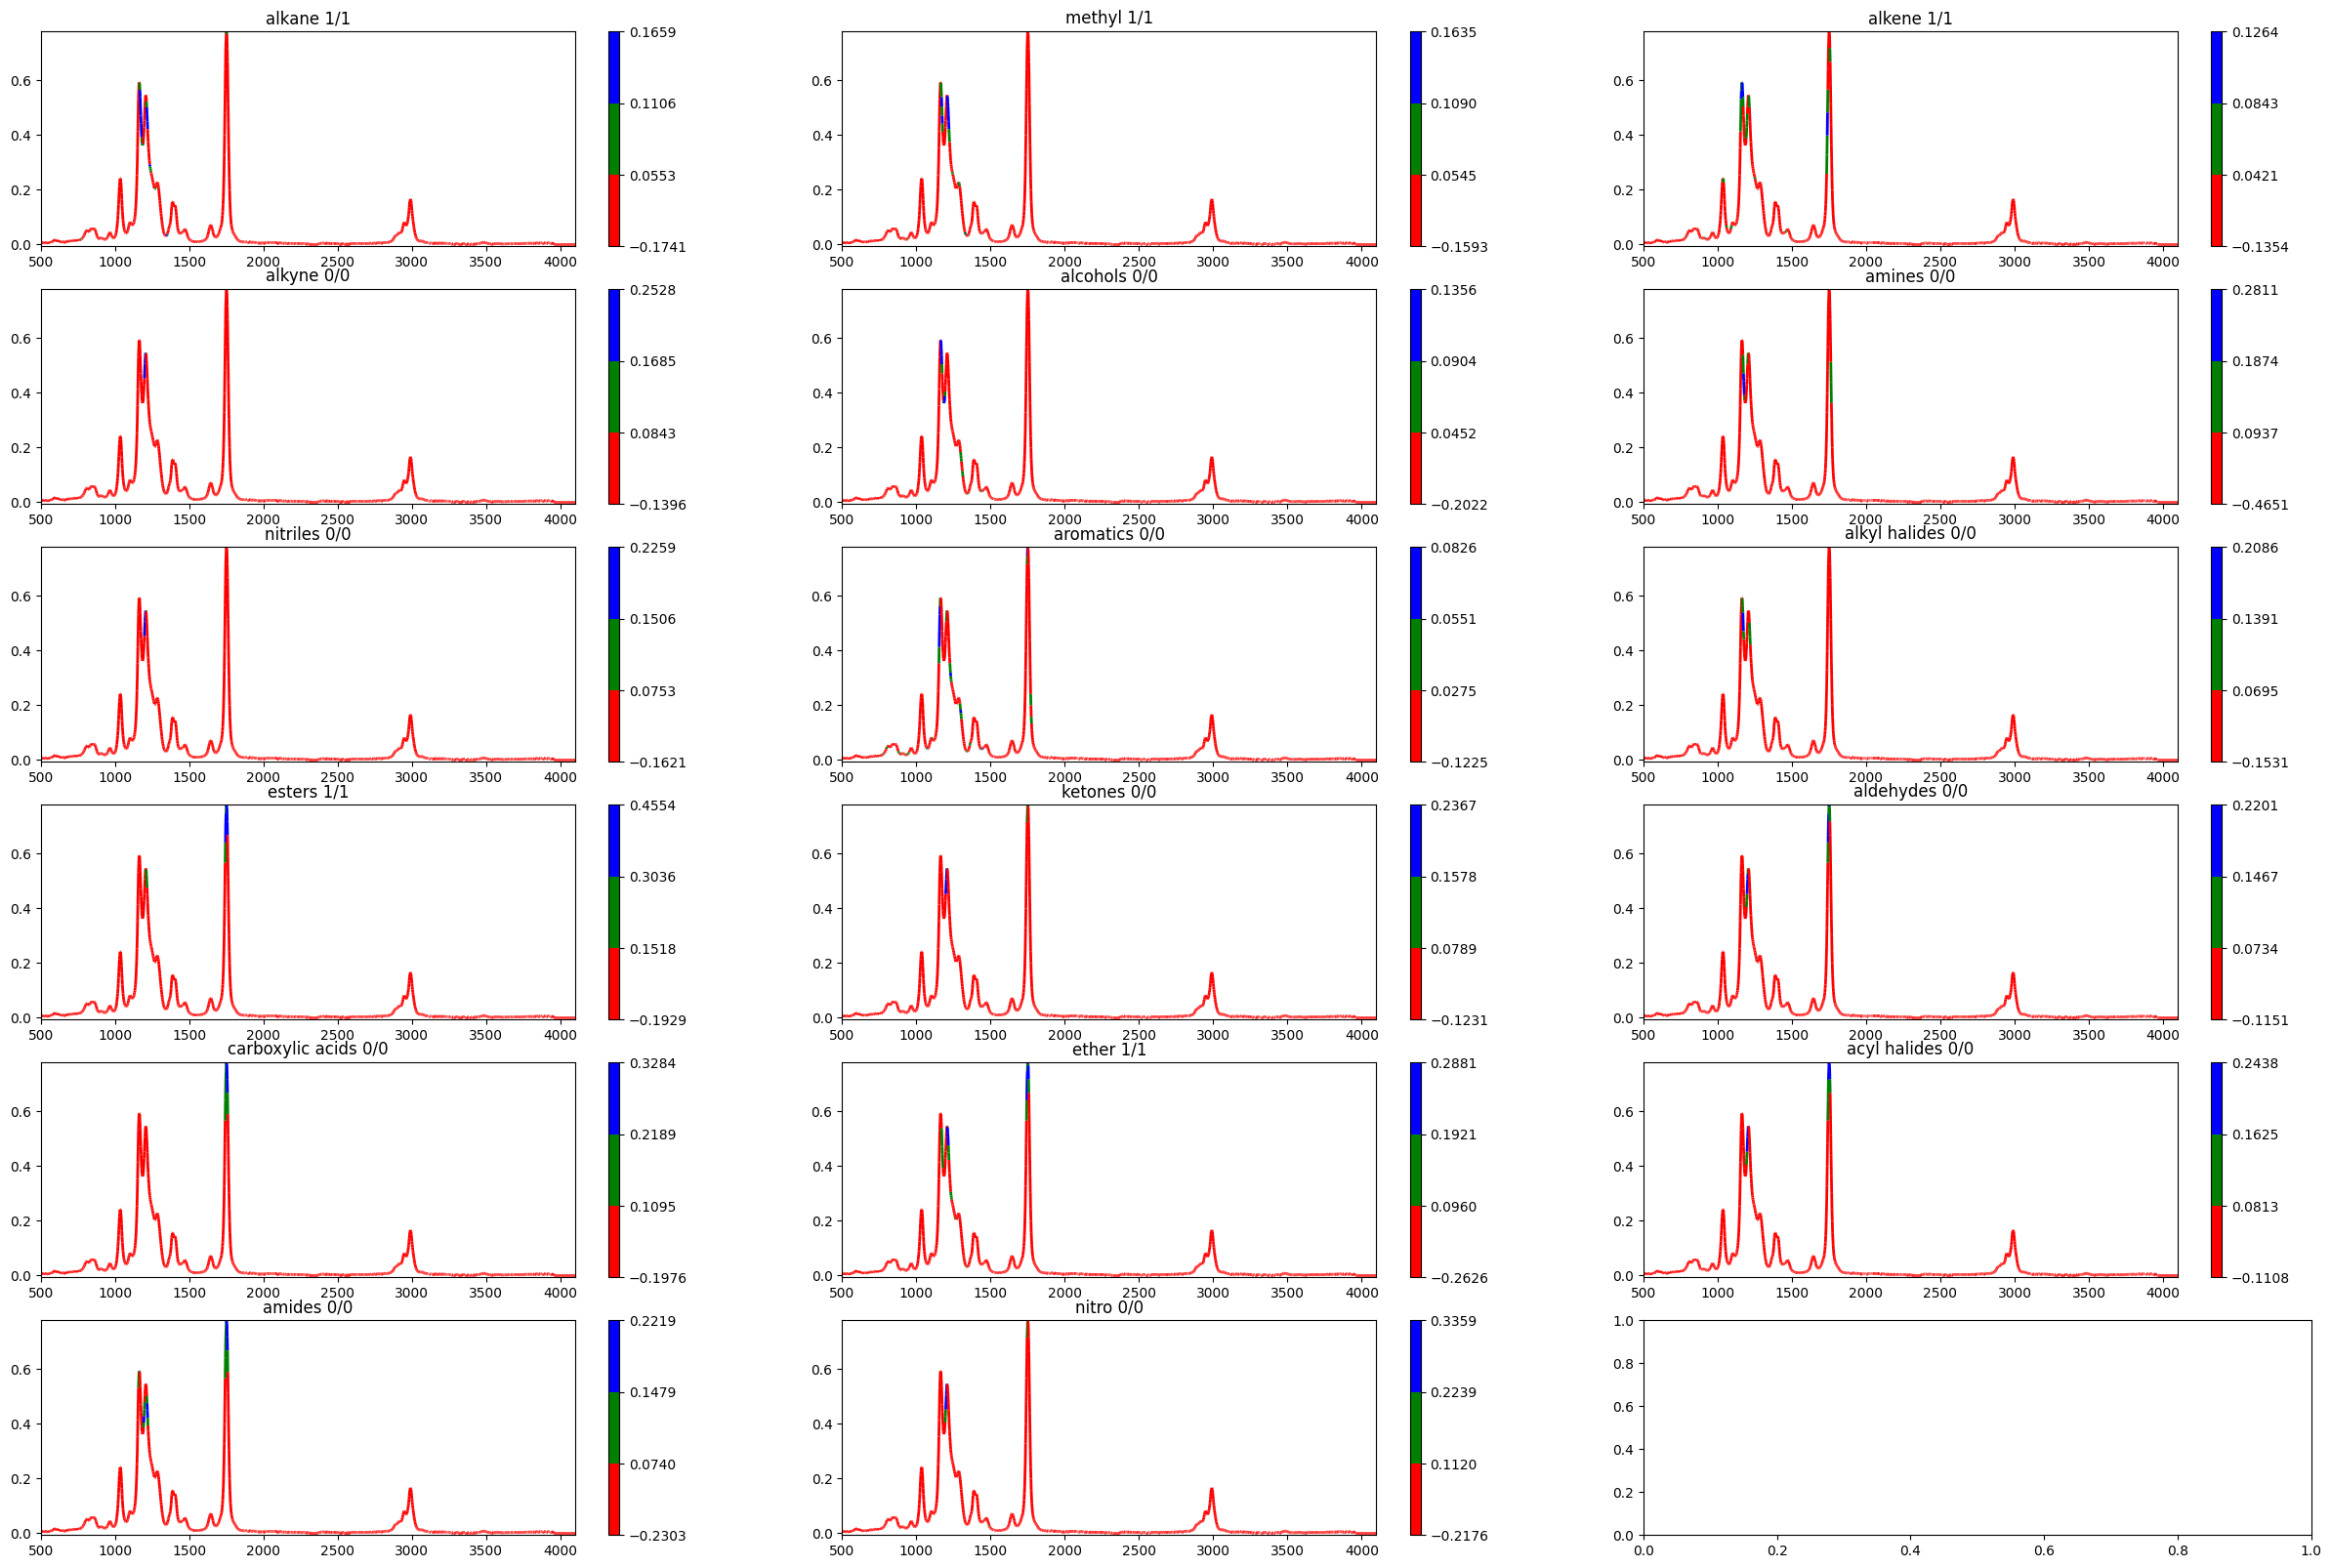

In [47]:
view_all_classes_shap(shap_values, inx2cls, 0,  mode = 'segments')

# Реализация GradCAM

https://colab.research.google.com/drive/1M2f0pHswAKZ-bpp5xhzW8EEOB7J77qla?usp=sharing#scrollTo=Q9h4QmPSa599

In [48]:
!pip install grad-cam
clear_output()

In [ ]:
batch = next(iter(dataloader_ir_test))
num = 5
test_specs, test_labels = batch
test_spec = test_specs[num]
test_label = test_labels[num]
test_spec = torch.unsqueeze(test_spec, dim=0)

In [ ]:
test_spec.size()

In [51]:
class ForwardHook():

    def __init__(self, layer):
        self.hook = layer.register_forward_hook(self.hook_func)

    def hook_func(self, layer, input_, output): 
        self.activation = output.detach().clone()

    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
      self.hook.remove()

In [52]:
with ForwardHook(model._modules['layer7']) as forward_hook:
    output = model.eval()(test_spec)
    activation = forward_hook.activation

print(activation.shape)

torch.Size([1, 400, 56])


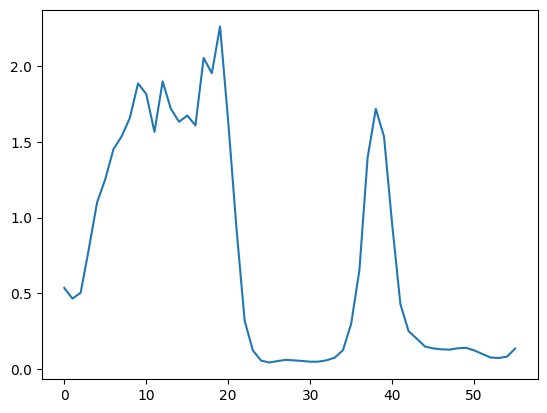

In [53]:
plt.plot(activation[0].T.mean(axis = 1))

In [54]:
import torch.nn.functional as F

number_of_top_classes = 6

prediction = F.softmax(output, dim=1)
top_props, top_inds = prediction.topk(number_of_top_classes)


for i in range(number_of_top_classes):
    category_name = inx2cls[top_inds[0][i].item()]
    score = top_props[0][i].item()
    print(f"{category_name} {top_inds[0][i].item()}: {100 * score:.1f}%")

ether 13: 41.9%
alkane 0: 26.5%
methyl 1: 19.3%
esters 9: 8.0%
alkene 2: 4.3%
aromatics 7: 0.0%


In [55]:
class HookBackward():
    def __init__(self, layer):
        self.hook = layer.register_backward_hook(self.hook_func) 

    def hook_func(self, layer, grad_input_, grad_output): 
        self.grad = grad_output[0].detach().clone().mean(dim=[2], keepdim=True)

    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
        self.hook.remove()

In [56]:
with HookBackward(model._modules['layer7']) as backward_hook:
        with ForwardHook(model._modules['layer7']) as forward_hook:
            output = model.eval()(test_spec)
            activation = forward_hook.activation
        output[0, top_inds[0][i]].backward()
        weight = backward_hook.grad
        cam_map = F.relu((weight[0] * activation[0]).sum(0)).detach().cpu()
print(output)
print(activation[0][0])
print(weight[0][0])
print((weight[0] * activation[0]).sum(0))

print(cam_map)
print(test_label)

tensor([[  5.7978,   5.4838,   3.9724,  -9.7073,  -5.6126,  -5.9927,  -7.4571,
          -3.3113,  -6.5858,   4.5999,  -5.4436,  -8.9162, -10.7494,   6.2579,
         -10.3805,  -5.7979, -11.8326]], grad_fn=<AddmmBackward0>)
tensor([0.0000, 0.9796, 1.0200, 0.0000, 2.8451, 0.0000, 1.1459, 6.0235, 0.0000,
        2.5553, 0.5365, 1.7286, 0.0000, 1.1683, 1.3772, 2.8581, 0.2309, 4.8751,
        0.6639, 1.0647, 0.0000, 0.2425, 1.4815, 0.5474, 0.3910, 0.4358, 0.1690,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2417, 0.0000, 0.0000,
        0.0000, 1.1506, 1.3612, 1.2736, 1.1206, 0.0000, 0.0000, 0.0000, 0.5065,
        0.5430, 0.6185, 0.9028, 0.9531, 0.6500, 0.0557, 0.0000, 0.0000, 0.0000,
        0.0000, 0.9195])
tensor([0.0002])
tensor([-0.0141, -0.0205, -0.0074, -0.0253, -0.0265, -0.0039, -0.0119,  0.0012,
         0.0285,  0.0327, -0.0369, -0.0360, -0.0009, -0.0129, -0.0526, -0.0573,
        -0.0725, -0.0326, -0.0313, -0.0379, -0.0545, -0.0438, -0.0181, -0.0030,
        -0.00

In [59]:
def get_cam_map(model, layer, img, class_num):
    with HookBackward(layer) as backward_hook:
        with ForwardHook(layer) as forward_hook:
            output = model.eval()(img)
            activation = forward_hook.activation
        output[0, class_num].backward()
        weight = backward_hook.grad
        cam_map = F.relu((weight[0] * activation[0]).sum(0)).detach().cpu()
    return cam_map

In [63]:
cam_map = get_cam_map(model, model._modules['layer7'], test_spec,  0)

In [78]:
cam_map.shape

torch.Size([56])

In [153]:
from scipy.interpolate import interp1d
def cam_map_interpolate(cam_map):
  cam_map_x = []
  for i in range(56):
    cam_map_x.append(i*3600/55+500)
  cam_map_x = torch.Tensor(cam_map_x)
  #print(len(cam_map_x))
  f = interp1d(cam_map_x, cam_map)
  cam_map_y = f(x)
  return cam_map_y

In [191]:
# plot the feature attributions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
def calc_cam_values(model, dataloader, layer, num_test_samples = 1):
  #Создаём тестовый объект
  batch = next(iter(dataloader))
  images, labels = batch
  if len(batch)>(100+num_test_samples):
     background = images[:100]
     test_images = images[100:(100+num_test_samples)]
     test_labels = labels[100:(100+num_test_samples)]
  else: 
    background = images[:(-num_test_samples-1)]
    test_images = images[(-num_test_samples-1):-1]
    test_labels = labels[(-num_test_samples-1):-1]
  model.eval()
  pred = model(test_images).detach().numpy()
  for i in range(len(pred)):
    pred[i][pred[i]>=0.5] = 1
    pred[i][pred[i]<0.5] = 0
  cam_map_all = []
  
  for image in test_images:
    cam_map_image = []
    #print(image.shape)
    image = image.unsqueeze(0)
    #print(image.shape)
    for i in range(17):
      cam_map = get_cam_map(model, layer, image, i)
      cam_map_image.append(cam_map_interpolate(cam_map))
    cam_map_all.append(cam_map_image)
  cam_plus_img = {}
  cam_plus_img['image'] = test_images
  cam_plus_img['cam_map'] = cam_map_all
  cam_plus_img['labels'] = test_labels
  cam_plus_img['pred'] = pred
  clear_output()
  return cam_plus_img

In [192]:
cam_plus_img = calc_cam_values(model, dataloader_ir_test, model._modules['layer7'], num_test_samples = 3)

In [194]:
len(cam_plus_img['cam_map'][0])

17

In [220]:
def plot_cam_continuous(x, y, row_num, col_num, fig, axs, cam_map, title):
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  if row_num*col_num <= 17:
            dydx = cam_map
            # Create a continuous norm to map from data points to colors
            norm = plt.Normalize(dydx.min(), dydx.max())
            lc = LineCollection(segments, cmap='copper', norm=norm)
            # Set the values used for colormapping
            lc.set_array(dydx)
            lc.set_linewidth(2)
            line = axs.add_collection(lc)
            fig.colorbar(line, ax=axs)
            axs.set_xlim(x.min()-0.00001, x.max()+0.000001)
            ly=y.max()
            axs.set_ylim(-0.01*ly, ly)
            axs.set_title(title)
            fig.set_figheight(20)
            fig.set_figwidth(30)
     
def plot_can_segments(x, y, row_num, col_num, fig, axs, cam_map, title):
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  if row_num*col_num <= 17:
            dydx = cam_map

            # Use a boundary norm instead
            cmap = ListedColormap(['r', 'g', 'y', 'b'])
            norm = BoundaryNorm([dydx.min()-0.000001, dydx.max()/3+0.0000003, dydx.max()*2/3+0.0000006, dydx.max()+0.000001], cmap.N)
            lc = LineCollection(segments, cmap=cmap, norm=norm)
            lc.set_array(dydx)
            lc.set_linewidth(2)
            line = axs.add_collection(lc)
            #print(line)
            fig.colorbar(line, ax=axs)
            axs.set_xlim(x.min(), x.max())
            ly=y.max()
            axs.set_ylim(-0.01*ly, ly)
            axs.set_title(title)
            fig.set_figheight(20)
            fig.set_figwidth(30)

def view_all_classes_cam(cam_plus_img, inx2cls, num = 0,  mode = 'segments'):
  test_spectra = cam_plus_img['image'][num]
  cam_map_all = cam_plus_img['cam_map'][num]
  test_labels = cam_plus_img['labels'][num]
  pred = cam_plus_img['pred'][num]
  x, y = test_spectra[:2]
  x, y = np.array(x), np.array(y)
  
  rows, cols = 6, 3
  fig, axs = plt.subplots(rows, cols, figsize=(5, 10))
  graph_nums = len(cam_map_all)
  if mode == 'continuous':
    for i in range(graph_nums):
      row = round(i//cols)
      col = i-row*cols
      label = list(np.array(test_labels, dtype = np.int32))[i]
      pred_title = list(np.array(pred, dtype = np.int32))[i]
      title = inx2cls[i]+' '+str(label)+'/'+str(pred_title)
      #print(title)
      plot_cam_continuous(x, y, row, col, fig, axs[row][col], cam_map_all[i], title)
      
   
  elif mode == 'segments':
    for i in range(graph_nums):
      row = round(i//cols)
      col = i-row*cols
      label = list(np.array(test_labels, dtype = np.int32))[i]
      pred_title = list(np.array(pred, dtype = np.int32))[i]
      title = inx2cls[i]+' '+str(label)+'/'+str(pred_title)
      
      plot_can_segments(x, y, row, col, fig, axs[row][col], cam_map_all[i], title)
      
  
  plt.show()


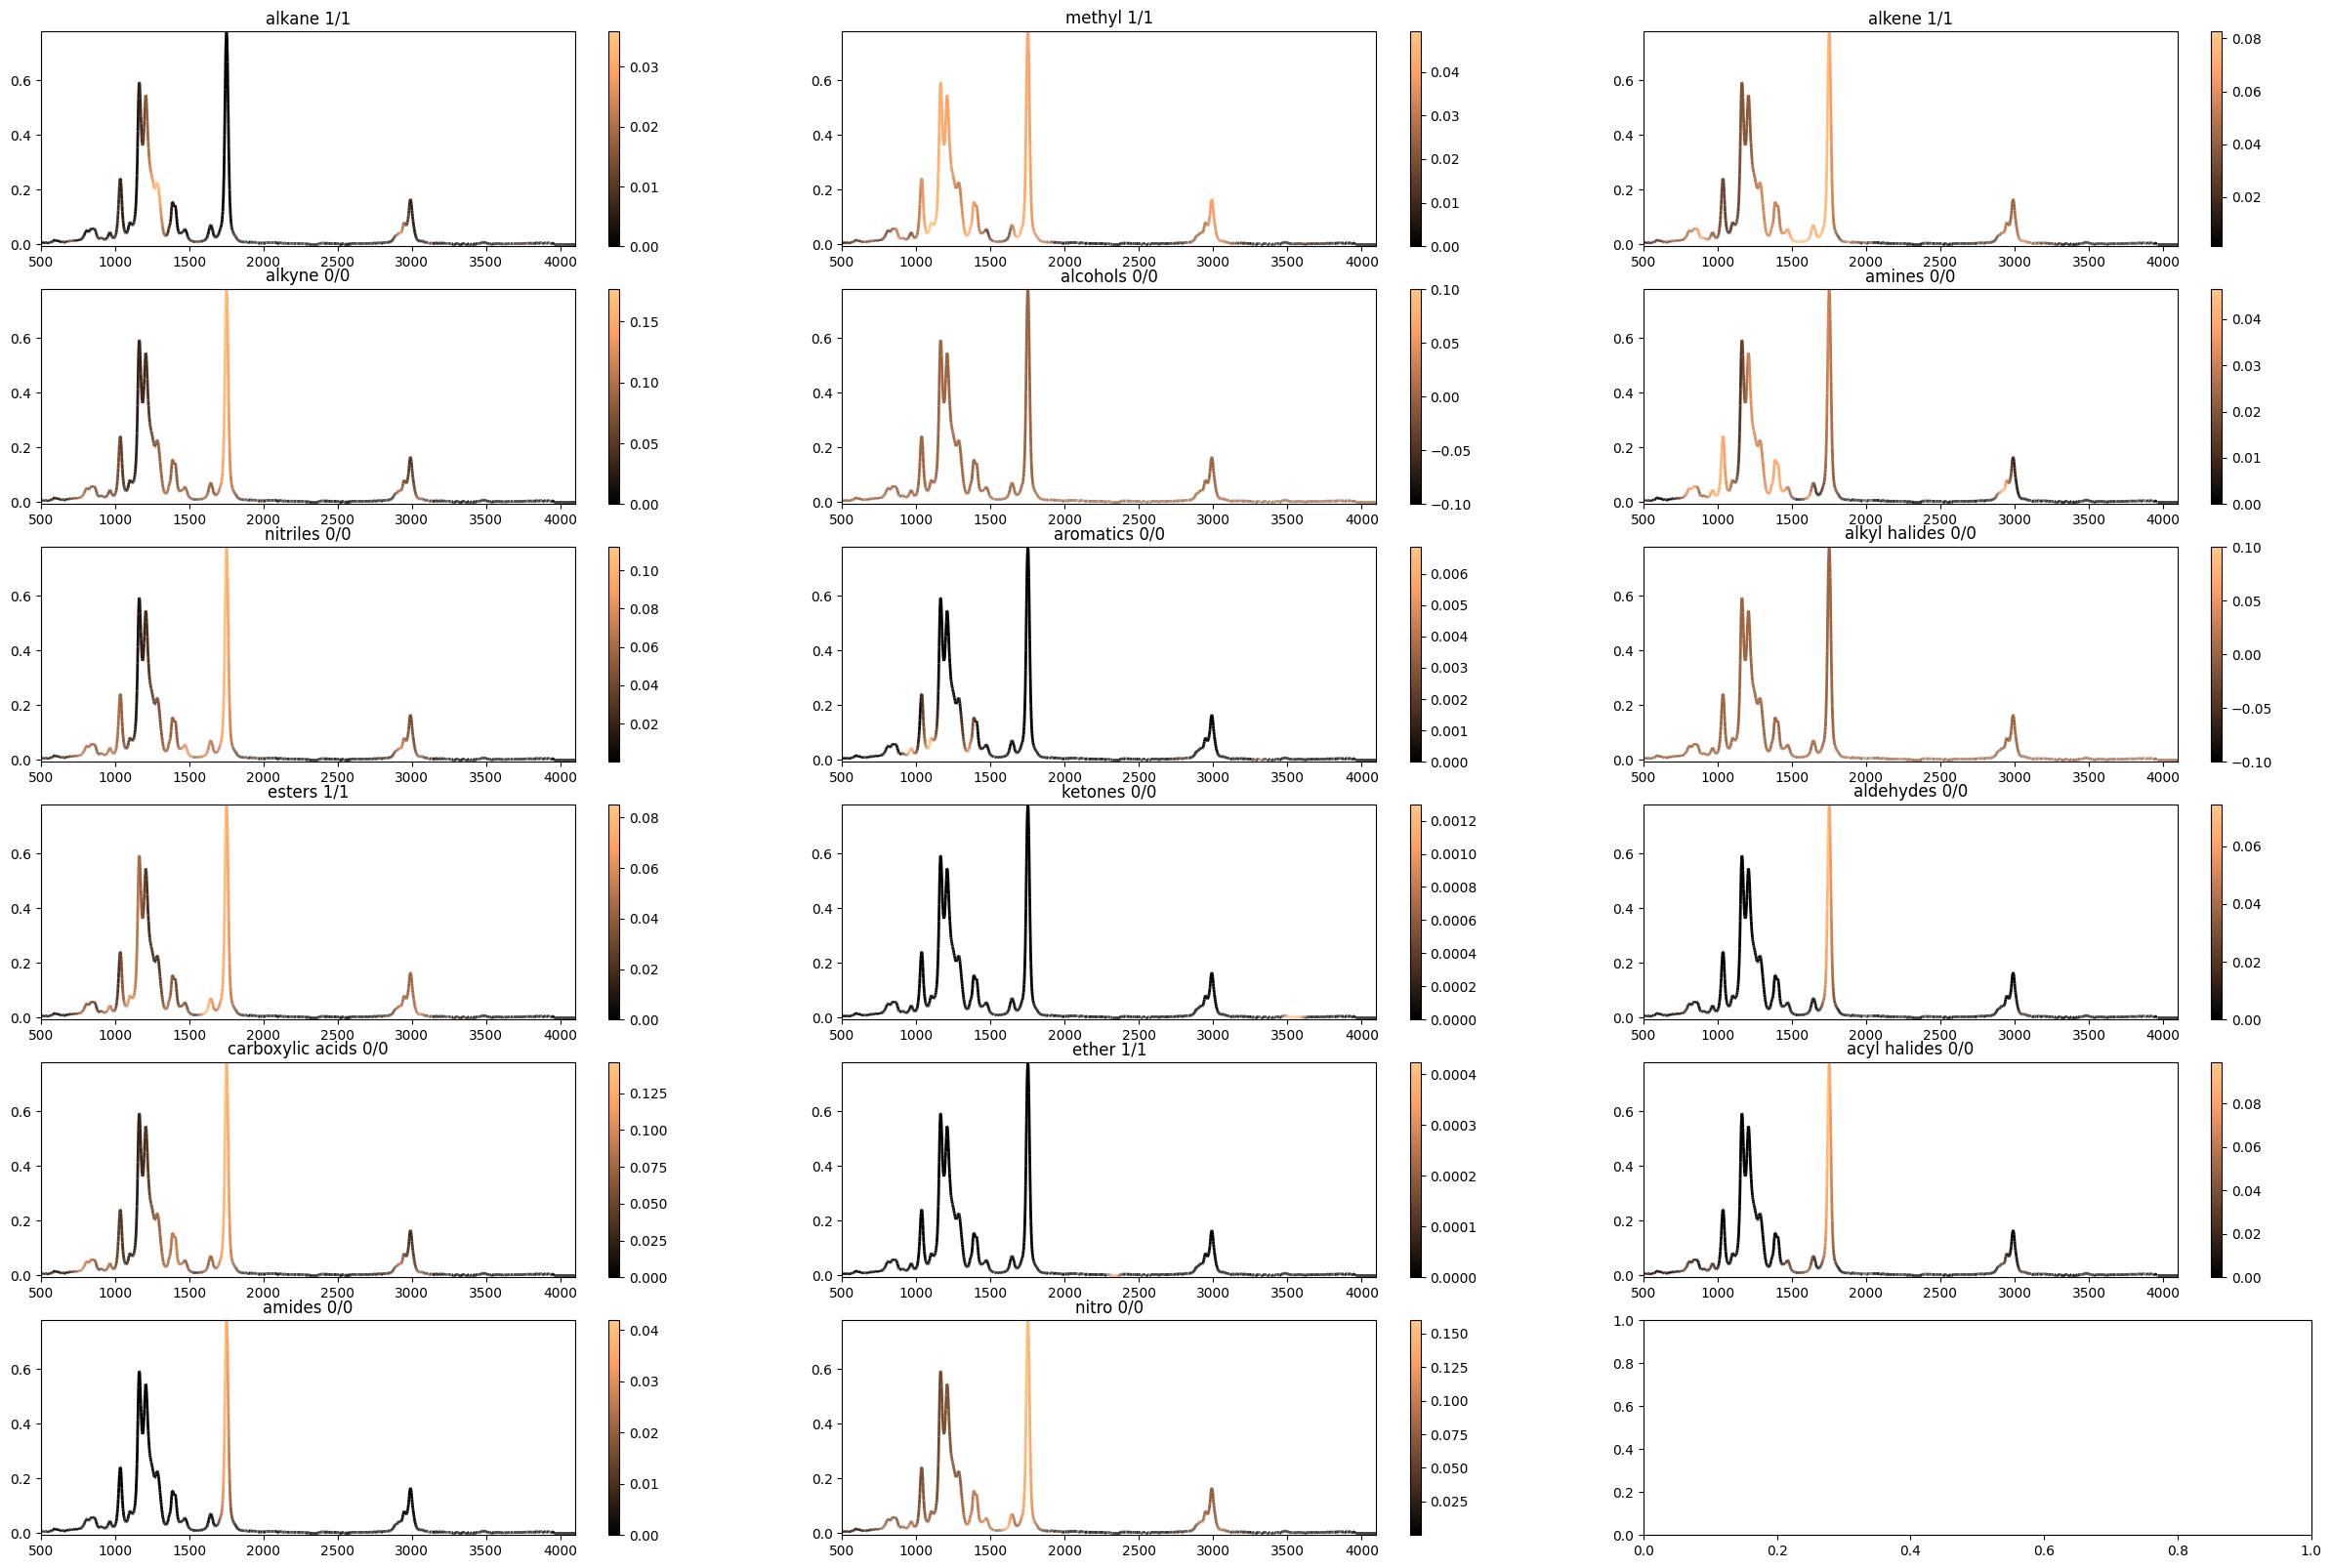

In [224]:
view_all_classes_cam(cam_plus_img, inx2cls, num = 0,  mode = 'continuous')

# Конец

## Сохранение модели